# Проект: вариант 2
### Задание 1. A/B–тестирование

**Условие**  
В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика.  
В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей. 

Необходимо ответить на следующие вопросы:  
На какие метрики Вы смотрите в ходе анализа и почему?  
Имеются ли различия в показателях и с чем они могут быть связаны?  
Являются ли эти различия статистически значимыми?  
Стоит ли запускать новую механику на всех пользователей?  

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from tqdm.auto import tqdm
import requests
from urllib.parse import urlencode
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(
    font_scale=1.2,
    style="darkgrid",
    rc={'figure.figsize': (12, 5)})

plt.style.use('ggplot')

**Получаем данные:**

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = ['https://disk.yandex.ru/d/58Us0DWOzuWAjg', 'https://disk.yandex.ru/d/3aARY-P9pfaksg', 
              'https://disk.yandex.ru/d/prbgU-rZpiXVYg', 'https://disk.yandex.ru/d/84hTmELphW2sqQ']
names = ['groups.csv', 'groups_add.csv', 'active_studs.csv', 'checks.csv']

In [3]:
for i, k in zip(public_key, names):
    final_url = base_url + urlencode(dict(public_key=i))
    response = requests.get(final_url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    with open(k, 'wb') as f:
        f.write(download_response.content)

**Изучаем датасеты:**

In [4]:
# файл с информацией о принадлежности пользователя к группе (А – контроль, B – целевая группа) 
groups = pd.read_csv('groups.csv', sep=';')

In [5]:
# дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
groups_add = pd.read_csv('groups_add.csv', sep=',')

In [6]:
# файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
active_studs = pd.read_csv('active_studs.csv', sep=',')

In [7]:
# файл с информацией об оплатах пользователей в дни проведения эксперимента. 
checks = pd.read_csv('checks.csv', sep=';')

In [8]:
df = [groups, groups_add, active_studs, checks]

In [9]:
for i in df:
    print(i.head())
    print('')

     id grp
0  1489   B
1  1627   A
2  1768   B
3  1783   B
4  1794   A

        id grp
0  5694584   B
1  5694830   B
2  5695057   B
3  5698872   B
4  5699067   B

   student_id
0      581585
1     5723133
2     3276743
3     4238589
4     4475369

   student_id    rev
0        1627  990.0
1        3185  690.0
2       25973  690.0
3       26280  690.0
4      100300  990.0



In [10]:
# получаем информацию о размерах, типах значений и ниличии пропущенных значений
for i in df:
    print(i.info())
    print('')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      N

In [11]:
# есть ли дубликаты
for i in df:
    print(i.duplicated().sum())

0
0
0
0


В данных отсутствуют пропуски и дубликаты - можно начинать работу с ними.

**Соберем файлы в датасет для анализа**

In [12]:
# соединим данные о принадлежности пользователя к контрольной или экспериментальной группе
all_users = groups.append(groups_add)

In [13]:
# сверим суммарное количество записей на всякий случай
all_users.shape[0] - groups.shape[0] - groups_add.shape[0]

0

In [14]:
# обогатим полученный датасет данными об активности и покупках
active_studs['active'] = 1
checks['purch'] = 1

In [15]:
df = all_users.merge(active_studs, how='outer', left_on='id', right_on='student_id').fillna(0)

In [16]:
df = df.merge(checks, how='outer', left_on='id', right_on='student_id').fillna(0)

In [17]:
df = df[['id', 'grp', 'active', 'rev', 'purch']]

In [18]:
df.head()

,id,grp,active,rev,purch
0,1489,B,0.0,0.0,0.0
1,1627,A,1.0,990.0,1.0
2,1768,B,0.0,0.0,0.0
3,1783,B,0.0,0.0,0.0
4,1794,A,0.0,0.0,0.0


Размеры контрольной А и тестовой В групп

In [19]:
len(df[df['grp'] == 'A'])

14693

In [20]:
len(df[df['grp'] == 'B'])

59883

**Проанализируем результаты А/В теста**

Чтобы понять, стоит ли запускать новую механику оплаты на всех пользователей, нужно рассмотреть как минимум три метрики:  
**1.CR (Conversion rate)** конверсию в покупку - так как механика оплаты является одним из основных факторов, влияющих на событие покупки. Рассчитывается как количество уникальных платящих пользователей / количество уникальных активных пользователей.  
**2.ARPPU (Average Revenue Per Paying User)**- влияет ли механика оплаты на средний доход, который приносит платящий пользователь.
**3.Медианный чек** - для дополнительной проверки.

Для расчета и анализа метрик возьмем как активных пользователей которые зашли на платформу в дни проведения эксперимента так и  заплативших, по видимому, авансом, т.к. они не заходили на платформу, но т.к. будем изучать метрики, связанные именно с покупками, их необходимо включить для получения полной картины.

In [21]:
df_active = df[(df['active'] == 1) | (df['purch'] == 1)]

Рассчитаем конверсию в покупку по группам

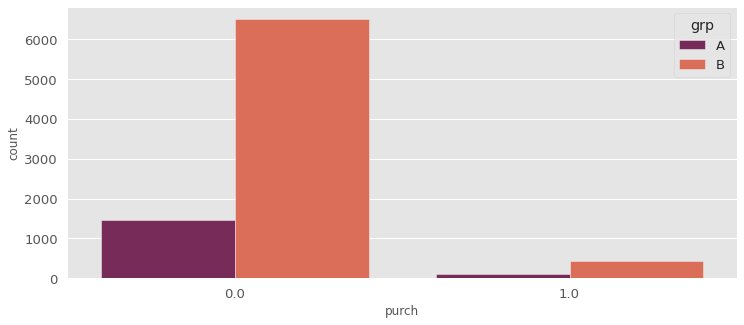

In [22]:
sns.countplot(x="purch", hue="grp", data=df_active, palette='rocket');

In [23]:
# Конверсия в покупку
for i in ['A', 'B']:
    con_ = round(df_active[(df_active['grp'] == i) & (df_active['purch'] == 1)]
                 .id.count() / df_active[df_active['grp'] == i].id.count() * 100, 2)
    print(f'Конверсия в покупку для группы {i} равна {con_}')

Конверсия в покупку для группы A равна 6.83
Конверсия в покупку для группы B равна 6.27


Конверсия в группах А и В отличается, но необходимо проверить гипотезу о взаимосвязи между переменными с помощью статистического теста.  
Так как имеются две категориальные переменные , используем хи-квадрат.  
- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [24]:
pd.crosstab(df_active.grp, df_active.purch)

purch,0.0,1.0
grp,,
A,1460,107
B,6489,434


In [25]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_active.grp, df_active.purch))

In [26]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Уровень значимости p < 0.05, а значит полученные отклонения являются статзначимыми - отклоняем H0')
else:
    print('Уровень значимости p > 0.05, а значит полученные отклонения не являются статзначимыми - не отклоняем H0')

Уровень значимости p > 0.05, а значит полученные отклонения не являются статзначимыми - не отклоняем H0


**Расчитаем ARPPU и медианный чек по группам**

In [27]:
Metrics_group = df_active.query('purch == 1').groupby('grp').agg({'rev': ['mean', 'median']}).round(2)

In [28]:
Metrics_group

rev       
        mean median
grp                
A     860.71  690.0
B    1108.82  935.0

На первый взгляд, различия существенны, но необходимо проверить эту гипотезу.

**Посмотрим распределение сумм покупок**

In [29]:
df_ = df_active.query('purch == 1 ')

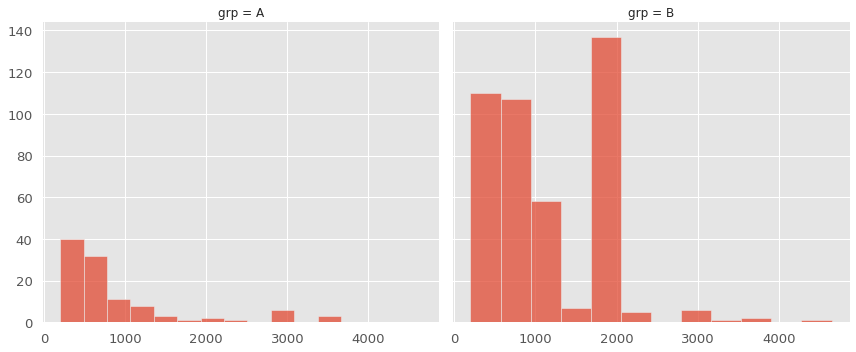

In [30]:
g = sns.FacetGrid(df_, col='grp', height=5, aspect=1.2)
g.map_dataframe(sns.histplot, x='rev');

В тестовой группе по сравнению с контрольной наблюдается аномально большое число покупок услуги за 1900 руб - возможно ошибки?

In [31]:
df_[df_['grp'] == 'B'].rev.value_counts().head()

1900.0000    97
290.0000     63
690.0000     59
199.0000     39
1900.0001    36
Name: rev, dtype: int64

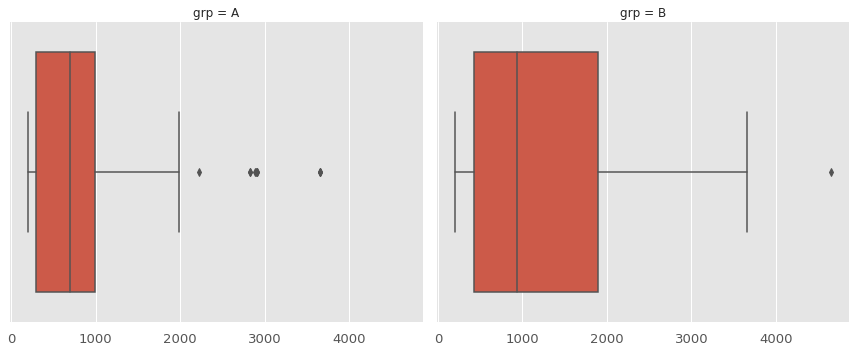

In [32]:
g = sns.FacetGrid(df_, col='grp', height=5, aspect=1.2)
g.map_dataframe(sns.boxplot, x='rev');

Из графика понятно, что распределение не является нормальным, поэтому чтобы проверить гипотезу о равенстве средних в группах A и В как наиболее удобный и универсальный метод можно применить bootstrap, т.к. Манн-Уитни проверяет гипотезу о равенстве распределений.

**Применим бутстрап**

- $H_0$: средние (медианы) выборок равны или разница между средними (медианами) равна нулю.
- $H_1$: средние (медианы) выборок не равны или разница между средними (медианами) не равна нулю.

In [33]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1,                      # числовые значения первой выборки
    data_column_2,                      # числовые значения второй выборки
    boot_it=1000,                       # количество bootstrap-подвыборок
    statistic=np.mean,                  # интересующая нас статистика
    bootstrap_conf_level=0.95           # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):          # извлекаем подвыборки
        samples_1 = data_column_1.sample(boot_len, replace=True).values
        
        samples_2 = data_column_2.sample(boot_len, replace=True).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))    
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])     
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=60, linestyle='--', colors='black')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci}

**для ARPPU**

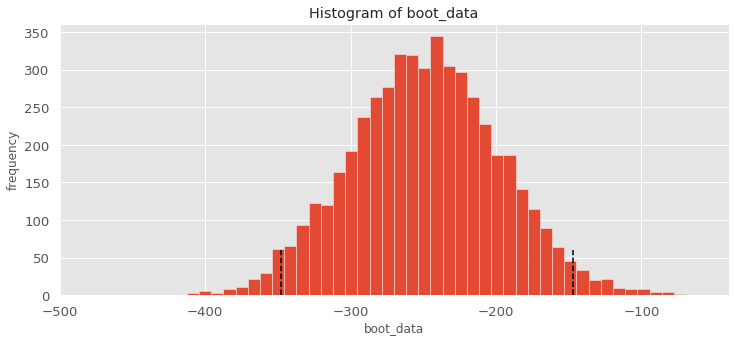

In [34]:
booted_data_mean = get_bootstrap(df_active.query("purch == 1 and grp == 'A'").rev, 
                                 df_active.query("purch == 1 and grp == 'B'").rev, boot_it=5000)

In [35]:
booted_data_mean["ci"]

,0
0.025,-347.829503
0.975,-146.861415


Так как в 95% случаев 0 не попадает в доверительный интервал, рассчитанный по бутстреп-выборкам, можно сделать вывод, что полученные отклонения в значениях средних являются статзначимыми - отклоняем H0

**Для медианного чека**

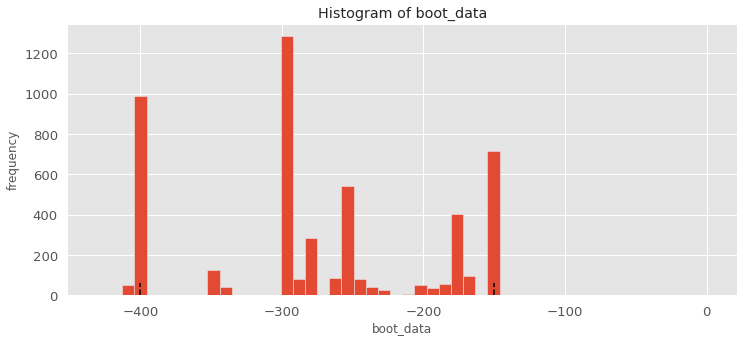

In [36]:
booted_data_median = get_bootstrap(df_active.query("purch == 1 and grp == 'A'").rev, 
                                   df_active.query("purch == 1 and grp == 'B'").rev, 
                                   boot_it=5000, statistic=np.median)

In [37]:
booted_data_median["ci"]

,0
0.025,-400.0
0.975,-150.0


Так как в 95% случаев 0 не попадает в доверительный интервал, рассчитанный по бутстреп-выборкам, можно сделать вывод, что полученные отклонения в значениях медиан являются статзначимыми - отклоняем H0

**Выводы:**
1. В контрольной группе А конверсия в покупку составила 6,83%, для тестовой группы этот же показатель стал равным 6,27%, снижение конверсии составило около 8%, но это с огромной долей вероятности случайное отклонение и применение новой механики оплаты услуг на сайте не влияет на конверсию в платящего пользователя.
2. Для контрольной группы ARPPU равен 860.71 р., а для тестовой 1108.82 р., увеличение составило около 22% и результаты стат. теста показали, что применение новой механики оплаты услуг на сайте с вероятностью 95% положительно влияет на ARPPU.
3. Аналогично для значений медианных чеков для котрольной и тестовой группы 690.0 р. и 935 р. соответственно - рост составил около 36% и результаты стат. теста также показали с вероятностью 95% наличие положительного влияния применение новой механики на размер медианного чека.
4. По результатам интерпретации тестов можно применить новую версию для всех пользователей. Но имеются некоторые странности в поведении пользователей - аномально высокие оплаты в контрольной группе и очень частые покупки услуги за 1900 р. в тестовой. Нужна дополнительная информация чтобы сделать окончательный вывод.